In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import math
import seaborn as sns
import numpy as np
import os

from sklearn import model_selection
from sklearn import metrics

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import Counter

import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, plot_precision_recall_curve

In [8]:
df=pd.read_csv('/Users/nicole/Desktop/aug_train.csv')

# Data Preprocessing

In [11]:
# OneHotEncoding
dfd = pd.get_dummies(df.drop(columns='enrollee_id'))

In [12]:
dfd.head()

,city_development_index,training_hours,target,city_city_1,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,0.920,36,1.0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0.776,47,0.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0.624,83,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.789,52,1.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0.767,8,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
X = dfd.drop(columns = 'target').values
y = dfd.target.values

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# Feature Scaling

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model building

## XGBoost
XGBoost can handle imbalance data set and missing value. So we keep null value and no need to do upsampling.

In [17]:
params_xgb = {
    'objective':'binary:logistic',
             'scale_pos_weight':2.5,
             'eval_metric':'aucpr',
              'missing':None,
             'seed':42,
        'reg_lambda':5,
         'reg_alpha':2
}

In [18]:
model_xgbSK = xgb.XGBClassifier(**params_xgb)
model_xgbSK.fit(X_train,
              y_train,
             verbose=True,
             early_stopping_rounds=20,
             eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

y_pred = model_xgbSK.predict(X_test)
importance = model_xgbSK.feature_importances_
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.52106
[1]	validation_0-aucpr:0.53087
[2]	validation_0-aucpr:0.53290
[3]	validation_0-aucpr:0.53548
[4]	validation_0-aucpr:0.54855
[5]	validation_0-aucpr:0.55485
[6]	validation_0-aucpr:0.55108
[7]	validation_0-aucpr:0.55555
[8]	validation_0-aucpr:0.55068
[9]	validation_0-aucpr:0.54886
[10]	validation_0-aucpr:0.54987
[11]	validation_0-aucpr:0.55308
[12]	validation_0-aucpr:0.55503
[13]	validation_0-aucpr:0.55606
[14]	validation_0-aucpr:0.55810
[15]	validation_0-aucpr:0.56081
[16]	validation_0-aucpr:0.56138
[17]	validation_0-aucpr:0.56158
[18]	validation_0-aucpr:0.55987
[19]	validation_0-aucpr:0.56073
[20]	validation_0-aucpr:0.56113
[21]	validation_0-aucpr:0.56062
[22]	validation_0-aucpr:0.55930
[23]	validation_0-aucpr:0.55957
[24]	validation_0-aucpr:0.55761
[25]	validation_0-aucpr:0.55788
[26]	validation_0-aucpr:0.55916
[27]	validation_0-aucpr:0.55937
[28]	validation_0-aucpr:0.55970
[29]	validation_0-aucpr:0.55978
[30]	validation_0-aucpr:0.55927
[31]	validation_0-

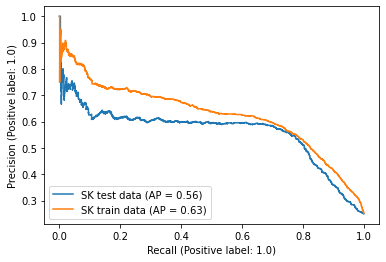

In [19]:
fig, axes = plt.subplots()
plot_precision_recall_curve(model_xgbSK, X_test, y_test, ax=axes, name="SK test data")
plot_precision_recall_curve(model_xgbSK, X_train, y_train, ax=axes, name="SK train data")

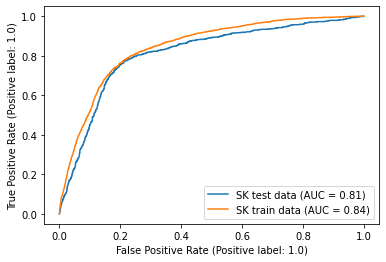

In [20]:
fig, axes = plt.subplots()
metrics.plot_roc_curve(model_xgbSK, X_test, y_test,ax=axes, name="SK test data")
metrics.plot_roc_curve(model_xgbSK, X_train, y_train,ax=axes, name="SK train data")

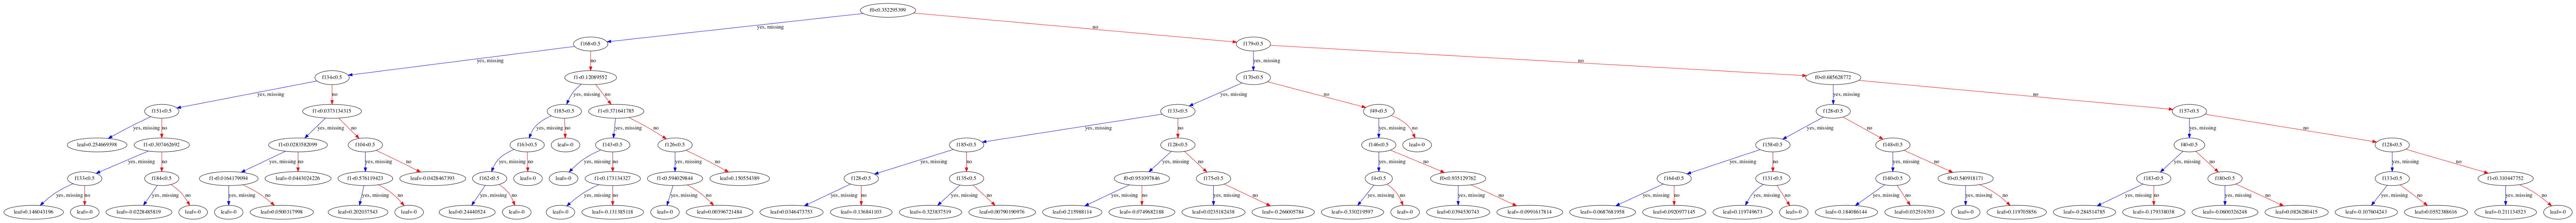

In [21]:
xgb.plot_tree(model_xgbSK, num_trees=1,fontsize=10)
fig = plt.gcf()
fig.set_size_inches(150,100)
plt.show()
# fig.savefig('tree.png')

## Catboost

CatBoost can handle imbalance data set and missing value. So we keep null value and no need to do upsampling.    
Catboost can handle categories with string, so we do not need to use onehotencoding.

In [22]:
dfC = df.drop(columns = 'enrollee_id').copy()
dfC.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [23]:
# change nan value into str or int, so Catbbost can handle it
# For categorical data, use 'NaN'
for i in ['company_size','company_type','enrolled_university',
          'education_level','last_new_job','experience','major_discipline','gender','city']:
    dfC[i] = dfC[i].fillna('NaN')

In [24]:
X = dfC.drop(columns='target')
y = dfC.target

In [41]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,stratify=y)

In [44]:
X_train.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
17855,city_21,0.624,NaN,Has relevent experience,no_enrollment,Graduate,STEM,10,50-99,Pvt Ltd,1,90
17664,city_103,0.920,Male,No relevent experience,no_enrollment,Primary School,NaN,5,NaN,NaN,never,15
13404,city_50,0.896,Male,Has relevent experience,no_enrollment,Graduate,STEM,12,1000-4999,NGO,>4,36
13366,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,100-500,Funded Startup,1,53
15670,city_67,0.855,Female,Has relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,1,158


In [50]:
X_train.iloc[:,[1,11]]

,city_development_index,training_hours
17855,0.624,90
17664,0.920,15
13404,0.896,36
13366,0.920,53
15670,0.855,158
...,...,...
10398,0.855,94
859,0.920,16
10566,0.893,34
3085,0.624,112


In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train.iloc[:,[1,11]] = scaler.fit_transform(X_train.iloc[:,[1,11]])
X_test.iloc[:,[1,11]] = scaler.transform(X_test.iloc[:,[1,11]])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [52]:
X_train.iloc[:,[1,11]]

,city_development_index,training_hours
17855,0.351297,0.265672
17664,0.942116,0.041791
13404,0.894212,0.104478
13366,0.942116,0.155224
15670,0.812375,0.468657
...,...,...
10398,0.812375,0.277612
859,0.942116,0.044776
10566,0.888224,0.098507
3085,0.351297,0.331343


In [54]:
# list of categorial features
cat_features = [0,2,3,4,5,6,7,8,9,10]

In [55]:
# Initialize CatBoostClassifier
model_cat = CatBoostClassifier(iterations=400,
                           learning_rate=0.05,
                            eval_metric='AUC',
                            auto_class_weights='Balanced',# handle inbalance
                               depth = 8
#                               scale_pos_weight = 2.5
                              )
# Fit model
model_cat.fit(X_train, 
          y_train, 
          cat_features,
              verbose_eval=20,
             early_stopping_rounds=20,
            eval_set=[(X_test,y_test)],
              plot=True
             )
# # # Get predicted classes
y_pred = model_cat.predict(X_test)
# # # Get predicted probabilities for each class
preds_proba = model_cat.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7820168	best: 0.7820168 (0)	total: 77.8ms	remaining: 31.1s
20:	test: 0.8111371	best: 0.8113629 (18)	total: 1.74s	remaining: 31.4s
40:	test: 0.8162837	best: 0.8165392 (37)	total: 2.84s	remaining: 24.9s
60:	test: 0.8173410	best: 0.8181204 (56)	total: 3.88s	remaining: 21.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8181204243
bestIteration = 56

Shrink model to first 57 iterations.


In [57]:
y_pred = model_cat.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.784


In [58]:
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85      2877
         1.0       0.55      0.78      0.65       955

    accuracy                           0.79      3832
   macro avg       0.73      0.78      0.75      3832
weighted avg       0.82      0.79      0.80      3832

[[2272  605]
 [ 211  744]]


In [59]:
from catboost import CatBoostClassifier, Pool
train_data = Pool(X_train,
                  y_train,
                  cat_features)

In [60]:
importance = pd.DataFrame({'feature_importance': model_cat.get_feature_importance(train_data), 
              'feature_names':X_train.columns}).set_index('feature_names').sort_values(by=['feature_importance'],ascending=False)

importance

,feature_importance
feature_names,
company_size,25.383930
city_development_index,23.090435
city,16.220480
education_level,7.016695
company_type,6.464046
experience,4.498095
last_new_job,4.063423
relevent_experience,3.912553
enrolled_university,3.111182


<AxesSubplot:ylabel='feature_names'>

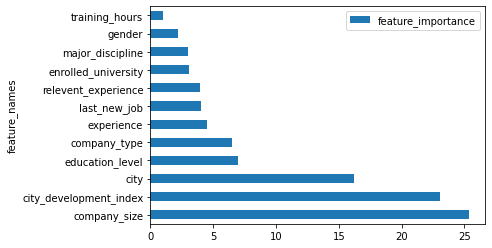

In [61]:
importance.plot(kind = 'barh')

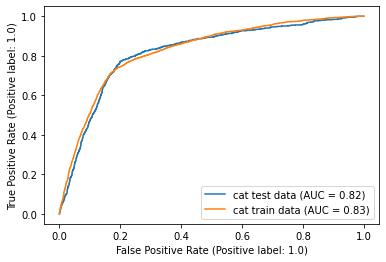

In [63]:
from sklearn import metrics
fig, axes = plt.subplots()
metrics.plot_roc_curve(model_cat, X_test, y_test,ax=axes, name="cat test data")
metrics.plot_roc_curve(model_cat, X_train, y_train,ax=axes, name="cat train data")

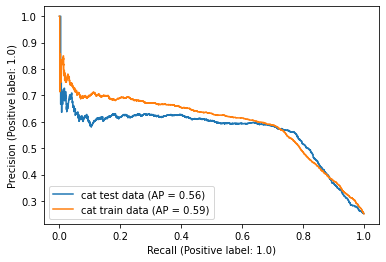

In [64]:
from sklearn.metrics import plot_precision_recall_curve
fig, axes = plt.subplots()
plot_precision_recall_curve(model_cat, X_test, y_test, ax=axes, name="cat test data")
plot_precision_recall_curve(model_cat, X_train, y_train, ax=axes, name="cat train data")

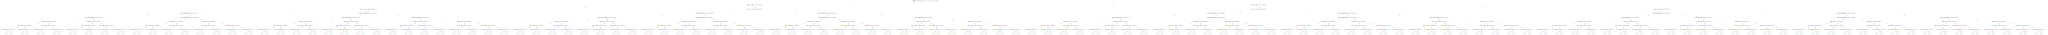

In [62]:
# Plot tree
model_cat.plot_tree(
    tree_idx=1,
    pool=train_data
)